In [1]:
# # For tips on running notebooks in Google Colab, see
# # https://pytorch.org/tutorials/beginner/colab
# %matplotlib inline

Transfer Learning for Computer Vision Tutorial
==============================================

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning. You can read
more about the transfer learning at [cs231n
notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


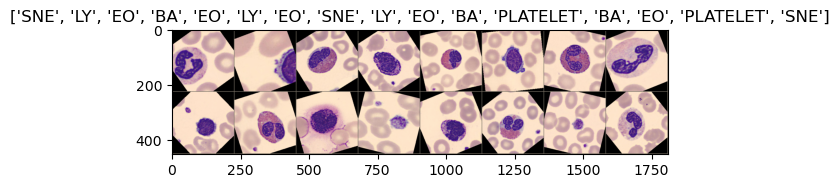

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_val_acc = 100

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), "./model_wbc_resnet50.pth")

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [7]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_ft.load_state_dict(torch.load("ckpts/model_wbc_resnet50_v2.pth"))

<All keys matched successfully>

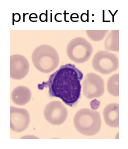

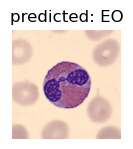

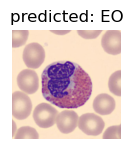

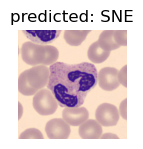

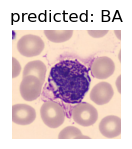

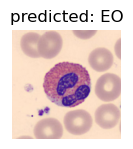

In [22]:
visualize_model(model_ft)

## Draw the TSNE plot

In [23]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [24]:
model_ft.avgpool.register_forward_hook(get_activation('avgpool'))

In [25]:
import tqdm
labels = []
outputs = torch.zeros((0,2048))

In [26]:
for (inputs, label) in tqdm.tqdm(dataloaders['val'], desc='Running the model inference'):
    images = inputs.to(device)
    labels += list(label.numpy())
 
    output = model_ft.forward(images)
 
    current_outputs = activation['avgpool'].squeeze().cpu().numpy()
    outputs = np.concatenate((outputs, current_outputs))

Running the model inference: 100%|██████████| 72/72 [00:03<00:00, 21.52it/s]


In [27]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto',  init='random', perplexity=20, n_iter=10000)

In [28]:
%%time
X_2d = tsne.fit_transform(outputs)

CPU times: user 5min 21s, sys: 2.54 s, total: 5min 24s
Wall time: 13.5 s


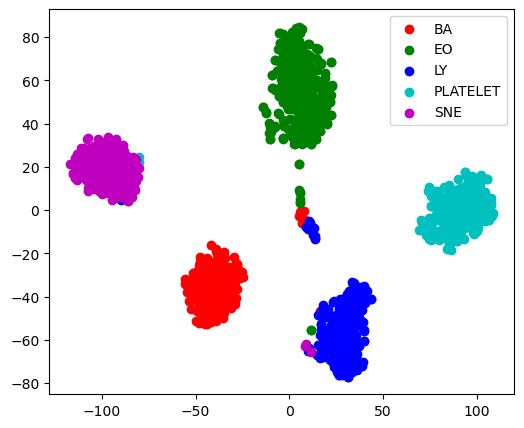

In [29]:
# target_ids = range(labels)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
colors = colors[:len(np.unique(labels))]
for i, c, label in zip(np.unique(labels), colors, np.unique(labels)):
    plt.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], c=c, label=class_names[label])

plt.legend()
plt.show()